# Graph Generation basato su attributi testuali
Obiettivo di questo notebook è quello di generare per ogni PA e Aggiudicatario una rappresentazione in uno spazio multidimensionale. Questa rappresentazione verrà usata per generare un grafo G(V,E) dove l'insieme dei nodi V rappresenta PA e Aggiudicatari, mentre l'insieme degli archi E definisce relazioni di similarità tra i nodi.

Si definisce di seguito la soluzione proposta.


## Soluzione 1: creazione di vettori basati sul tf-idf

Ogni bando di gara è caratterizzato da un campo *oggetto*. Quindi per ogni elemento *i* ∈ { PA ⋃  Fornitori }, dove PA (Fornitori) è l’insieme delle Pubbliche amministrazioni (Fornitori) presenti nel dataset Anac,  è possibile creare un documento sintetico d<sub>i</sub> ottenuto concatenando il testo di tutti gli oggetti delle gare appartenenti ad *i*.

A partire da D = {d<sub>i</sub> | i ∈ { PA ⋃  Fornitori}} è possibile creare la matrice W ∈ R<sup>(n,m)</sup>, ottenuta calcolando il TF-IDF su D.

In questo modo è possibile creare un grafo G_text(V, E) dove V = { PA ⋃ Fornitori } ed esiste un arco pesato e = {(u, v) ∈ E | p(e) = cos(w<sub>u</sub>, w<sub>v</sub>)}  solo e soltanto se cos(w<sub>u</sub>, w<sub>v</sub>) >= *threshold*.

cos(w<sub>u</sub>, w<sub>v</sub>) ∈ [0,1], dove 0 implica che i documenti d<sub>u</sub>, d<sub>v</sub> sono completamente diversi, mentre 1 implica che i documenti hanno la stessa distribuzione di termini.


**Note**

- Dati i ∈ {PA} e j ∈ {Fornitori}, è possibile che se tutte le gare vinte da j riguardassero sempre i come struttura proponente (PA) e se tutte le gare di i siano vinte da j allora d<sub>i</sub> == d<sub>j</sub>, quindi cos(w<sub>i</sub>, w<sub>j</sub>) = 1.

- E’ possibile aggiungere al grafo G<sub>text</sub> nuovi nodi come l’insieme delle provincie e regioni. In questo caso è possibile associare ad ogni provincia (regione) i un documento sintentico d_i ottenuto concatenando tutti gli oggetti delle PA che insistono su i.  

- La matrice W non gestisce casi si sinonimia e polisemia (problema risolto con la soluziione successiva);

## Soluzione 2: creazione di vettori basati su word embedding dei top term

   Come nel precedente caso per ogni elemento i ∈ { PA ⋃  Fornitori }, dove PA (Fornitori) è l’insieme delle Pubbliche amministrazioni (Fornitori) presenti nel dataset Anac,  è possibile creare un documento sintetico d<sub>i</sub> ottenuto concatenando il testo di tutti gli oggetti delle gare appartenenti ad i. 

Sia *L* l’insieme delle top n ∈ N parole più frequenti (in termine di tf-idf)  e *D* = {d’<sub>i</sub> | i ∈ { PA ⋃  Fornitori } }, dove d’<sub>i</sub> = {(l, w) | l ∈ L e w = TF-IDF(l, d<sub>i</sub>)}. 

In questo modo per ogni i è possibile costruire un vettore v<sub>i</sub>  dato dalla somma pesata degli embedding dei termini l contenuti in d’<sub>i</sub>. 
Per esempio, sia  L = [“fattura”, “acquisto”, “fornitura”] l’insieme dei top 3 termini in D, e sia D ={d<sub>1</sub>, d<sub>2</sub>, d<sub>3</sub>}, dove:

- d<sub>1</sub> = [(“acquisto”: w(1,acquisto)), (“fattura”: w(1,fattura))]  
- d<sub>2</sub> = [(“fattura”: w(2,fattura)), (“fornitura”: w(2,fornitura))]  
- d<sub>3</sub> = [(“acquisto”: w(3,acquisto)), (“fattura”: w(3,fattura)), (“fornitura”: w(3,fornitura))]

Quindi è possibile per ogni d<sub>i</sub> calcolare una rappresentazione vettoriale

 
$\sum_{(tj,wj)∈di}$ w<sub>j</sub> * embedding(t<sub>j</sub>)
    
    
 

dove embedding(t<sub>j</sub>) è l’embedding del termine t<sub>j</sub> appreso su Wikipedia (vedi [qui](https://fasttext.cc/docs/en/support.html) per maggiori dettagli).

In questo modo è possibile creare un grafo G<sub>text</sub>(V, E) dove V = { PA ⋃ Fornitori } ed esiste un arco pesato e = {(u, v) ∈ E | p(e) = cos(v<sub>du</sub>, v<sub>dv</sub>)}  solo e soltanto se cos(v<sub>du</sub>, v<sub>dv</sub>) >= threshold.






In [2]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

import pandas as pd
import numpy  as np
import csv
import datetime
from time import time

#%matplotlib inline

import plotly.offline as py
import plotly.plotly as py_on
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

from IPython.display import Image
from IPython.display import display

import matplotlib.pyplot as plt

In [ ]:
file = "data/anac/anac_indicepa_2017.tsv"
df = pd.read_csv(file, sep="\t")
df.info(memory_usage='deep')

## Creazione dei documenti sintetici d<sub>i</sub>

In questa sezione, per ogni attributo in *columns_to_aggregate*, è calcolato il documento sintetico per ogni occorrenza dello stesso

In [ ]:
columns_to_aggregate = {("cfStrutturaProponente","PA"), ("cfPrimoaggiudicatario","AGG")}

In [ ]:
def aggregateByOggetto(col_groupBy, col_toAgg, df):
    """
    col_groupBy: è la colonna per la quale effettuare l'aggragazione
    col_toAgg: è la colonna contenente le informazioni non strutturate, i.e. campo "oggetto"
    df: input dataframe
    """
    df_noEmpty = df.dropna(subset=[col_toAgg], axis=0)
    new_series = df_noEmpty.groupby(col_groupBy)[col_toAgg].apply(lambda x: ' '.join(x)) 
    return pd.DataFrame(new_series)

In [ ]:
final_df = pd.DataFrame(columns=['codiceFiscaleStruttura', 'oggetto', "tipoStruttura"])

In [ ]:
for col, type_col in columns_to_aggregate:
    t0 = time()
    aggregate_df = aggregateByOggetto(col, "oggetto", df) 
    total = time() - t0

    aggregate_df['tipoStruttura'] = [type_col] * aggregate_df.shape[0]
    aggregate_df.rename(columns={col: 'codiceFiscaleStruttura'})

    final_df = final_df.append(aggregate_df)
    
    print("Aggregation of attribute %s done in %0.3f sec" % (col, total))
    print(aggregate_df["oggetto"].head(3))


In [ ]:
t0 = time()
file_name = "data/oggetti_aggregati.pickle"
final_df.to_pickle(file_name)
total = time() - t0

print("Dataset stored in %0.3f sec" % total)

In [ ]:
#rilascia la memoria associata al DataFrame
del [[df, final_df]]

## Implementazione Soluzione 1

In [3]:
from nltk.stem.snowball import ItalianStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.csr import csr_matrix #need this if you want to save tfidf_matrix
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

class StemmedCountVectorizer(TfidfVectorizer):
    
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([italian_stemmer.stem(w) for w in analyzer(doc)])
        
def get_TFIDFmatrix_vect(data, do_stemming):
    """
    data: input textual collection
    do_stemming: boolean. If True execute stemming, otherwise analyze only tokenized words (words are composed at least 2 chars and do not contains numbers)
    """
    t0 = time()
    
    if do_stemming:
        
        italian_stemmer = ItalianStemmer()
        tf = StemmedCountVectorizer(token_pattern=u'([a-z]{2,})', max_features=1000, analyzer="word", stop_words=stopwords.words('italian'))

    else:
        tf = TfidfVectorizer(token_pattern=u'([a-z]{2,})', stop_words=stopwords.words('italian'), max_features=1000) #CountVectorizer supports counts of N-grams of words or consecutive characters.
    
    matrix = tf.fit_transform(data)  
    return matrix, tf

def plotTopNWords(sorted_frequents_words, N, title):
    """frequents_words: list of frequents words. Type: tuple(str, numpy.int64)
       N: number of words to plot 
    """
    #most_frequents_words = sorted(sorted_frequents_words, key = lambda x: x[1], reverse=True)
    x, y = zip(*sorted_frequents_words[1:N]) # unpack a list of pairs into two tuples

    fig = plt.figure()
    ax1 = fig.add_subplot(111)  # Create matplotlib axes
    ax1.set_title(title)
    ax1.plot(x, y)

    for tl in ax1.get_xticklabels():
        tl.set_rotation(90)

    file_name = 'imgs/top'+str(N)+'_words_plot.png'  
    fig.tight_layout() 
    plt.savefig(file_name, pad = 0) #png

    plt.clf
    return file_name

In [4]:
file_name = "data/oggetti_aggregati.pickle"

t0 = time()
df = pd.read_pickle(file_name)
total = time() - t0

print("Dataset loaded in %0.3f sec" % total)

Dataset loaded in 1.301 sec


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 262964 entries, 8010803 to zzintl50p49e532p
Data columns (total 3 columns):
codiceFiscaleStruttura    0 non-null object
oggetto                   262964 non-null object
tipoStruttura             262964 non-null object
dtypes: object(3)
memory usage: 8.0+ MB


In [6]:
t0 = time()

matrix, tf = get_TFIDFmatrix_vect(df.oggetto, False)
total = time() - t0
print("TFIDF matrix done in %0.3f sec" % total)

TFIDF matrix done in 47.322 sec


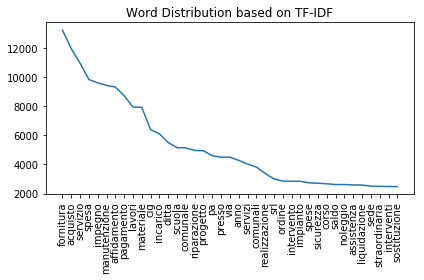

In [7]:
top_terms = 40

#Tf-Idf distribution
scores = zip(tf.get_feature_names(), np.asarray(matrix.sum(axis=0)).ravel())
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
file_name = plotTopNWords(sorted_scores, top_terms,  "Word Distribution based on TF-IDF")

In [9]:
matrix.shape

(262964, 1000)

In [ ]:
##Clustering with DBSCAN

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler


if matrix.shape[0] > 100:
    #Standardize features by removing the mean and scaling to unit variance
    t0 = time()
    scaled_tfidf_matrix = StandardScaler().fit_transform(matrix.toarray())
    total = time() - t0
    print("Standardization done in %0.3f sec" % total)
    
    # Compute DBSCAN
    t0 = time()
    db = DBSCAN(algorithm = 'ball_tree', min_samples=10, n_jobs=-1).fit(scaled_tfidf_matrix)
    
    labels = db.labels_
    total = time() - t0
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print("Clustering done in done in %0.3f sec" % total)
    print('Estimated number of clusters: %d' % n_clusters_)
    print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(scaled_tfidf_matrix, labels))
    
    df_aggiudicatario["label"] = labels

Standardization done in 46.379 sec


In [ ]:
from gensim.models import KeyedVectors


In [ ]:
time()

In [10]:
from sklearn.cluster import DBSCAN
DBSCAN?